# Grad cam on best model
adapted from https://github.com/ismailuddin/gradcam-tensorflow-2/blob/master/notebooks/GradCam.ipynb


In [4]:
%matplotlib inline

In [97]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import cv2

In [127]:
IMG_SIZE = 256 
# index to ethnicity 
i2e = {1: "Asian", 2:"Caucasian", 3:"African-American"}

meta_data = pd.read_csv("/kaggle/input/meta-data-hcml/meta_data.csv")
# use same encoding 
meta_data['Gender'] = meta_data["Gender"].replace(2, 0) # so women are 0 now

In [116]:
model = keras.models.load_model("/kaggle/input/model-vggface/vggface_v3_0.h5")
# [(l, l.name) for l in model.layers[0].layers]

In [117]:
from tensorflow.keras.models import Sequential

flat_layers = model.layers[0].layers
flat_layers += [l for l in model.layers[1:]]

flat_model = Sequential()

for layer in flat_layers:
    flat_model.add(layer)
    
# flat_model.summary()
# flat_model.predict(np.expand_dims(image, axis=0))[0][0]

In [118]:
last_conv_layer_model = Sequential()

for layer in flat_model.layers:
    if layer.name == "conv5_3":
        break
        
    last_conv_layer_model.add(layer)

last_conv_layer_model.compile()

# test = last_conv_layer_model(tf.random.uniform((1, 256, 256, 3)))

In [120]:
classifier_input = tf.keras.Input(shape=flat_model.layers[-6].output.shape[1:])
x = classifier_input
for layer in flat_model.layers[-4:]:
    x = layer(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [130]:
def get_gradcam(image):
    
    with tf.GradientTape() as tape:
        inputs = image[np.newaxis, ...]
        inputs = tf.cast(inputs, tf.float32)
        last_conv_layer_output = last_conv_layer_model(inputs)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
    
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Average over all the filters to get a single 2D array
    gradcam = np.mean(last_conv_layer_output, axis=-1)
    # Clip the values (equivalent to applying ReLU)
    # and then normalise the values
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam[0], (IMG_SIZE, IMG_SIZE))

    return gradcam
    

1/1 [==============================] - 0s 407ms/step


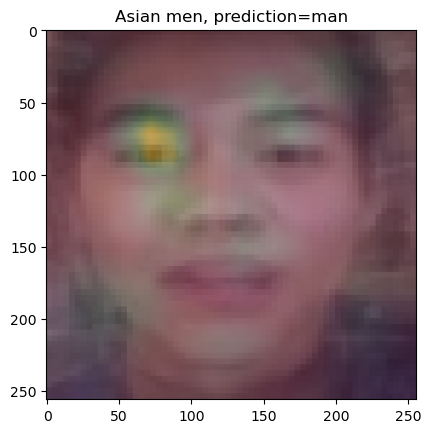

1/1 [==============================] - 0s 403ms/step


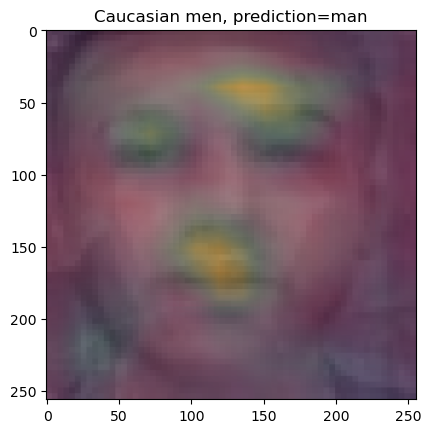

1/1 [==============================] - 0s 409ms/step


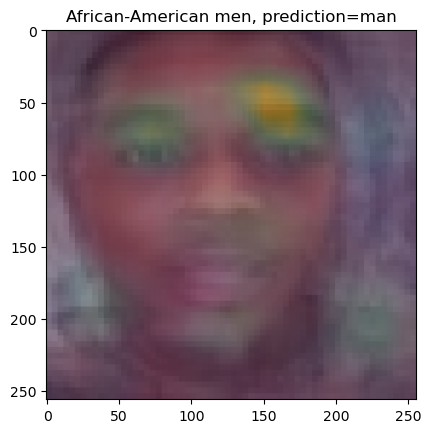

1/1 [==============================] - 0s 405ms/step


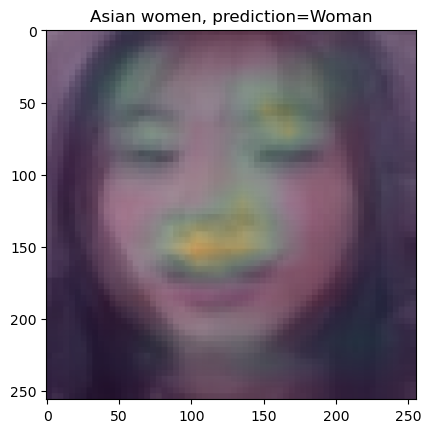

1/1 [==============================] - 0s 409ms/step


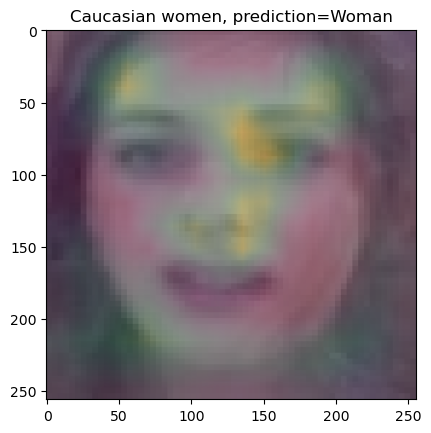

1/1 [==============================] - 0s 420ms/step


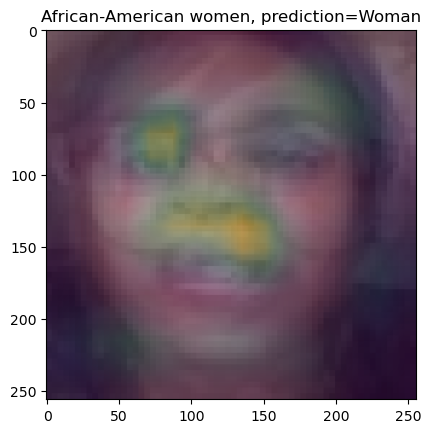

In [149]:
path_dict = {"men": {}, "women": {}}
for gender_i, gender_str in zip((0, 1), ("women", "men")):
    for ethnicity in (1, 2, 3):
        # get 10 unique paths for each ethnicity and gender from the test data 
        paths = meta_data.loc[(meta_data["Category"] == 1) & (meta_data["Ethnicity"] == ethnicity) & (meta_data["Gender"] == gender_i)]["VideoName"].values
        path_dict[gender_str][i2e[ethnicity]] = np.random.choice(paths, 10, replace=False)
        
for g, ethnicities in path_dict.items():
    for e, paths in ethnicities.items():
        image = np.zeros((IMG_SIZE, IMG_SIZE, 3))
        for path in paths:
            full_path = f"/kaggle/input/heysem-sorted-data/sorted_data/test/{g}/{path}.JPG"
            image += np.array(load_img(full_path, target_size=(IMG_SIZE, IMG_SIZE, 3)))
        
        avg_image = image / 10 / 255.0
        path_dict[g][e] = {"avg_image": avg_image}
        
        gradcam = get_gradcam(avg_image)
        pred = "man" if (model.predict(np.expand_dims(avg_image, axis=0)) < 0.5)[0][0] else "Woman"

        plt.imshow(avg_image)
        plt.imshow(gradcam, alpha=0.3)
        plt.title(f"{e} {g}, prediction is {pred}")
        plt.show()
        
#         break
#     break